In [1]:
class my_DecisionTreeClassifier():
    def __init__(self, max_depth = 2):
        self.max_depth = max_depth

    def get_score(self, y, criterion='gini'):
        self.ps = np.bincount(y)/len(y)
        return 1 - np.sum(self.ps ** 2)
    
    def split_score_gain(self, x, y, split_threshold):
        self.left_split = np.argwhere(x <= split_threshold).flatten()
        self.right_split = np.argwhere(x > split_threshold).flatten()
        self.y_smaller, self.y_bigger = y[self.left_split], y[self.right_split]

        self.left_n, self.right_n = len(self.left_split), len(self.right_split)
        self.child_score = (self.left_n * self.get_score(self.y_smaller) + self.right_n * self.get_score(self.y_bigger))/(self.left_n + self.right_n)

        return self.child_score, self.left_split, self.right_split

    def best_split(self, dataset):
        self.xx = dataset[:, :-1]
        self.yy = dataset[:, -1].astype(int)
        self.features = self.xx.shape[1]

        self.split_feature, self.split_threshold = 0, 0
        self.best_score = len(np.unique(self.yy)) - 1
        self.left_group, self.right_group = [], []
        self.x_column = []

        for i in range(self.features):
            self.x_column = self.xx[:, i]
            self.split_thresholds = np.unique(self.x_column)
            self.current_score = self.best_score

            for j in range(len(self.split_thresholds)):
                self.current_score, self.left_split, self.right_split = self.split_score_gain(self.x_column, self.yy, self.split_thresholds[j])

                if self.current_score < self.best_score:
                    self.best_score = self.current_score
                    self.split_feature = i
                    self.left_group, self.right_group = self.left_split, self.right_split

                    if j == len(self.split_thresholds) - 1:
                        self.split_threshold = self.split_thresholds[j]
                    else: 
    #                   giving the harmonic mean
                        self.split_threshold = np.around((2 * self.split_thresholds[j] * self.split_thresholds[j+1])/(self.split_thresholds[j] + self.split_thresholds[j+1]), 2)

                if self.current_score == 0:
                    break  
        return {'feature': self.split_feature,'threshold': self.split_threshold, 'left group': dataset[self.left_group], 'right group': dataset[self.right_group]}

    def max_class(self, y):
        return np.argmax(np.bincount(y[:, -1].astype(int)))

    def node_constructor(self, node, depth):
        left, right = [], []
        left, right = node['left group'], node['right group']
        del(node['left group'])
        del(node['right group'])

        if len(np.unique(left[:, -1])) == 1:
            node['left'] = self.max_class(left)

        else:
            node['left'] = self.best_split(left)
            self.node_constructor(node['left'], depth+1)

        if len(np.unique(right[:, -1])) == 1:
            node['right'] = self.max_class(right)
        else:
            node['right'] = self.best_split(right)
            self.node_constructor(node['right'], depth+1) 

        if depth >= self.max_depth:
            node['left'], node['right'] = self.max_class(left), self.max_class(right)
            return 

    def fit(self, train_data):
        self.root_split = self.best_split(train_data)
        self.node_constructor(self.root_split, 1)
        return self.root_split

    def predict_attribute(self, data_vector, node):
        if data_vector[node['feature']] <= node['threshold']:
            
            if isinstance(node['left'], (int, np.integer)): #terminal node
                return node['left']
            else:
                return self.predict_attribute(data_vector, node['left']) #continue
        else:
            if isinstance(node['right'], (int, np.integer)): #terminal node
                return node['right']
            else:
                return self.predict_attribute(data_vector, node['right']) # continue

    def predict(self, data_train, x_test):
        self.predictions = []
        self.decision_tree = self.fit(data_train)
        for i in x_test:
            self.prediction = self.predict_attribute(i, self.decision_tree)
            self.predictions.append(self.prediction)
        return(np.array(self.predictions))

    def accuracy(self, y_true, y_pred):
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy

In [2]:
import pandas as pd
import numpy as np
from collections import Counter


from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.datasets import load_iris

X, y = load_iris(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24)

train_data = np.c_[X_train, y_train]

my_dt = my_DecisionTreeClassifier(max_depth = 10)
my_dt.fit(train_data)
my_dt.predict(train_data, X_test)

array([2, 2, 1, 1, 2, 0, 0, 1, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2,
       2, 1, 2, 0, 2, 2, 0, 2, 1, 0, 2, 1, 2, 2, 0, 1])

In [3]:
train_data = np.c_[X_train, y_train]
test_data = np.c_[X_test, y_test]

my_dt = my_DecisionTreeClassifier(max_depth = 3)
print("max_depth =", 3)
y_pred = my_dt.predict(train_data, train_data)
print("accuracy on train data:", my_dt.accuracy(y_train, y_pred))

y_pred = my_dt.predict(train_data, X_test)
print("accuracy on test data:", my_dt.accuracy(y_test, y_pred))


my_dt = my_DecisionTreeClassifier(max_depth=12)
print("max_depth =", 12)
y_pred = my_dt.predict(train_data, train_data)
print("accuracy on train data:", my_dt.accuracy(y_train, y_pred))

y_pred = my_dt.predict(train_data, X_test)
print("accuracy on test data:", my_dt.accuracy(y_test, y_pred))

max_depth = 3
accuracy on train data: 0.9821428571428571
accuracy on test data: 0.9736842105263158
max_depth = 12
accuracy on train data: 1.0
accuracy on test data: 0.9736842105263158


In [4]:
# let's compare my tree with sklearn's one
my_dt.fit(train_data)

{'feature': 2,
 'threshold': 2.33,
 'left': 0,
 'right': {'feature': 3,
  'threshold': 1.65,
  'left': {'feature': 2,
   'threshold': 4.95,
   'left': 1,
   'right': {'feature': 0,
    'threshold': 6.05,
    'left': {'feature': 1, 'threshold': 2.42, 'left': 2, 'right': 1},
    'right': 2}},
  'right': {'feature': 2,
   'threshold': 4.85,
   'left': {'feature': 1, 'threshold': 3.1, 'left': 2, 'right': 1},
   'right': 2}}}

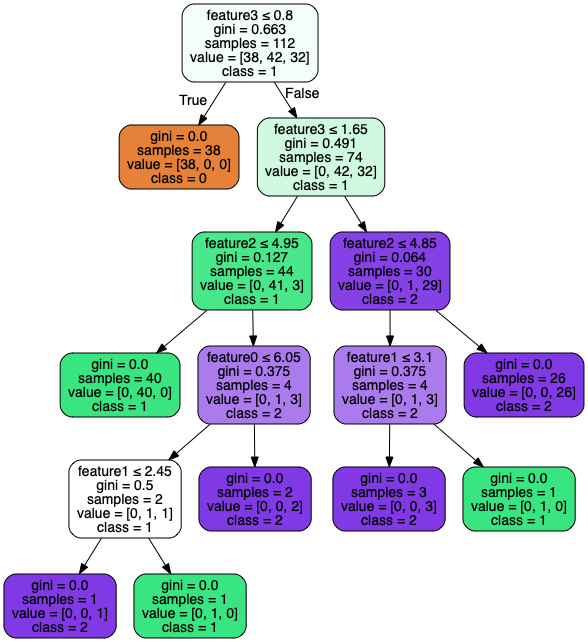

In [5]:
clf = DecisionTreeClassifier(max_depth=10)
clf.fit(X_train, y_train)

feature_cols = ['feature'+str(i) for i in range(len(X[0]))]
feature_cols

from sklearn.tree import export_graphviz
# from sklearn.externals.six import StringIO 
from io import StringIO
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1','2'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())

In [ ]:
# some differences are becouse for greedy search of best feature and threshold DecisionTreeClassifier
# randomely pickes the feature while I start from the 0-th feature and stop the search reaching 
# 0 gini index OR getting to the end and picking the feature and threshold that will 
# give the min gini after splitting